In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm, ensemble
from sklearn.ensemble import AdaBoostRegressor
import time
import matplotlib.pyplot as plt

weather = pd.read_csv('data/weather.csv')
pallet_history = pd.read_csv('data/Pallet_history_Gold_Spike.csv')
inbound = pd.read_csv('data/inbound_loads.csv')
outbound = pd.read_csv('data/outbound_laods.csv')
demand = pd.read_csv('data/demand_kWtrain_val.csv')

# Preprocessing the csv files

In [2]:
#################
# Preprocess inbound csv:
#################
print('\n #####\nInbound: \n ##### \n')
inbound_post = inbound[inbound.carrier_code != 'CANCEL']
inbound_post = inbound[inbound.carrier_code != '']

inbound_post['truck_signin_datetime'] = pd.to_datetime(inbound_post['truck_signin_datetime'])

# Compute delta times
inbound_load_time = pd.to_datetime(inbound_post['load_finish_datetime']) - pd.to_datetime(inbound_post['load_start_datetime'])
inbound_truck_time = pd.to_datetime(inbound_post['truck_signin_datetime']) - pd.to_datetime(inbound_post['signout_datetime'])

# Drop unnecessary columns
inbound_post = inbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
inbound_post['load_time'] = inbound_load_time
inbound_post['truck_time'] = inbound_truck_time

print(inbound_post.columns)

inbound_post['load_time'] = inbound_post['load_time'].dt.seconds
inbound_post['truck_time'] = inbound_post['truck_time'].dt.seconds

print('With NaN:', inbound_post.shape)

# Drop rows with >0 NaN values
inbound_post_nan = inbound_post.dropna().reset_index(drop=True)

print('Without NaN:', inbound_post_nan.shape)

#################
# Preprocess outbound csv:
#################
print('\n #####\nOutbound: \n ##### \n')
outbound_post = outbound[outbound.carrier_code != 'CANCEL']
outbound_post = outbound[outbound.carrier_code != 'VOID']
outbound_post = outbound[outbound.carrier_code != '']

outbound_post['truck_signin_datetime'] = pd.to_datetime(outbound_post['truck_signin_datetime'])

# Compute delta times
outbound_load_time = pd.to_datetime(outbound_post['load_finish_datetime']) - pd.to_datetime(outbound_post['load_start_datetime'])
outbound_truck_time = pd.to_datetime(outbound_post['truck_signin_datetime']) - pd.to_datetime(outbound_post['signout_datetime'])

# Drop unnecessary columns
outbound_post = outbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
outbound_post['load_time'] = outbound_load_time
outbound_post['truck_time'] = outbound_truck_time

print(outbound_post.columns)

outbound_post['load_time'] = outbound_post['load_time'].dt.seconds
outbound_post['truck_time'] = outbound_post['truck_time'].dt.seconds

print('With NaN:', outbound_post.shape)

# Drop rows with >0 NaN values
outbound_post_nan = outbound_post.dropna().reset_index(drop=True)

print('Without NaN:', outbound_post_nan.shape)

#################
# Preprocess demand csv:
#################
print('\n #####\nDemand:  \n ##### \n')

demand['datetime_local'] = pd.to_datetime(demand['datetime_local'])

end_known_idx = demand[demand.demand_kW > 1].index[-1]
train_val_split = 0.7 # 70% train, 30% val
end_train_idx = int((train_val_split) * end_known_idx)
demand_train = demand[0:end_train_idx-1]
demand_val = demand[end_train_idx:end_known_idx]

print('Full dataset:', demand.shape)
print('Answers known until index: ', end_known_idx)
print(f'Training set, {int(train_val_split*100)}%:', demand_train.shape)
print(f'Validation set, {int(100-train_val_split*100)}%:', demand_val.shape)

#################
# Preprocess weather csv:
#################
print('\n #####\nWeather:  \n ##### \n')

weather_post = weather.copy()
UTC6 = pd.to_datetime(weather_post['datetime_UTC']) - pd.Timedelta(hours=6)
weather_post['datetime_america'] = UTC6
weather_post = weather_post.drop('datetime_UTC', axis=1)
weather_post = weather_post.drop('datetime', axis=1)

print(weather_post.head())
print(weather_post.columns)
print(weather_post.shape)



 #####
Inbound: 
 ##### 

Index(['front_temperature', 'middle_temperature', 'back_temperature',
       'net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (56146, 9)
Without NaN: (8761, 9)

 #####
Outbound: 
 ##### 

Index(['net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (112363, 6)
Without NaN: (96704, 6)

 #####
Demand:  
 ##### 

Full dataset: (365349, 3)
Answers known until index:  273987
Training set, 70%: (191789, 3)
Validation set, 30%: (82197, 3)

 #####
Weather:  
 ##### 

   Unnamed: 0  Relative Humidity  Temperature  hour    datetime_america
0           0              50.37         53.6    18 2018-12-31 18:00:00
1           1              50.37         53.6    18 2018-12-31 18:05:00
2           2              50.37         53.6    18 2018-12-31 18:10:00
3           3              50.37         53.6 

# Merging csv files

### Inbound with demand:

In [3]:
inbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
demand_inbound_merge = pd.merge_asof(demand_train, inbound_post_nan, left_on='datetime_local', right_on='truck_signin_datetime', direction='nearest')

demand_inbound_merge_numerical = demand_inbound_merge.copy()
demand_inbound_merge_numerical['datetime_local'] = demand_inbound_merge_numerical['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))
demand_inbound_merge_numerical['truck_signin_datetime'] = demand_inbound_merge_numerical['truck_signin_datetime'].apply(lambda x: time.mktime(x.timetuple()))

print(demand_inbound_merge_numerical.head())

   Unnamed: 0  datetime_local    demand_kW  front_temperature  \
0           0    1.546287e+09  2064.101392               -4.0   
1           1    1.546288e+09  1874.002081               -4.0   
2           2    1.546289e+09  1988.168511               -4.0   
3           3    1.546290e+09  2022.795943               -4.0   
4           4    1.546291e+09  1986.981872               -4.0   

   middle_temperature  back_temperature  net_weight  case_quantity  \
0                -4.0              -4.0     45264.0         1476.0   
1                -4.0              -4.0     45264.0         1476.0   
2                -4.0              -4.0     45264.0         1476.0   
3                -4.0              -4.0     45264.0         1476.0   
4                -4.0              -4.0     45264.0         1476.0   

   pallet_count  truck_signin_datetime  load_time  truck_time  
0          24.0           1.546264e+09     1140.0     86399.0  
1          24.0           1.546264e+09     1140.0     86399.

Regression on train set

In [4]:
# Split the data into training and test sets
X = demand_inbound_merge_numerical.drop('demand_kW', axis=1)
y = demand_inbound_merge_numerical['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', AdaBoostRegressor())
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 135209.3376739463


### Adding outbound

In [5]:
outbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
outbound_merge = pd.merge_asof(demand_inbound_merge, outbound_post_nan, left_on='datetime_local', right_on='truck_signin_datetime', direction='nearest', suffixes=('_inbound', '_outbound'))

outbound_merge_numerical = outbound_merge.copy()
outbound_merge_numerical['datetime_local'] = outbound_merge_numerical['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))
outbound_merge_numerical['truck_signin_datetime_inbound'] = outbound_merge_numerical['truck_signin_datetime_inbound'].apply(lambda x: time.mktime(x.timetuple()))
outbound_merge_numerical['truck_signin_datetime_outbound'] = outbound_merge_numerical['truck_signin_datetime_outbound'].apply(lambda x: time.mktime(x.timetuple()))

print(outbound_merge_numerical.tail())

        Unnamed: 0  datetime_local  demand_kW  front_temperature  \
191784      191784    1.628928e+09   2561.692               41.0   
191785      191785    1.628928e+09   2864.648               41.0   
191786      191786    1.628928e+09   2820.785               41.0   
191787      191787    1.628928e+09   2817.942               41.0   
191788      191788    1.628928e+09   2699.152               41.0   

        middle_temperature  back_temperature  net_weight_inbound  \
191784                42.0              42.0             41198.0   
191785                42.0              42.0             41198.0   
191786                42.0              42.0             41198.0   
191787                42.0              42.0             41198.0   
191788                42.0              42.0             41198.0   

        case_quantity_inbound  pallet_count_inbound  \
191784                 1642.0                  28.0   
191785                 1642.0                  28.0   
191786           

Regression on train set

In [6]:
# Split the data into training and test sets
X = outbound_merge_numerical.drop('demand_kW', axis=1)
y = outbound_merge_numerical['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up pipeline parameters
params = {
    "n_estimators": 50,
    "learning_rate": 1,
    "loss": "square",
}

# Set up the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', AdaBoostRegressor(**params))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 257559.83837909932


### Adding weather

In [7]:
weather_post.sort_values("datetime_america", inplace=True)
weather_merge = pd.merge_asof(outbound_merge, weather_post, left_on='datetime_local', right_on='datetime_america', direction='nearest')

weather_merge_numerical = weather_merge.copy()
weather_merge_numerical['datetime_local'] = weather_merge_numerical['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))
weather_merge_numerical['truck_signin_datetime_inbound'] = weather_merge_numerical['truck_signin_datetime_inbound'].apply(lambda x: time.mktime(x.timetuple()))
weather_merge_numerical['truck_signin_datetime_outbound'] = weather_merge_numerical['truck_signin_datetime_outbound'].apply(lambda x: time.mktime(x.timetuple()))
weather_merge_numerical['datetime_america'] = weather_merge_numerical['datetime_america'].apply(lambda x: time.mktime(x.timetuple()))

print(weather_merge_numerical.shape)


(191789, 23)


Regression on train set

In [8]:
# Split the data into training and test sets
X = weather_merge_numerical.drop('demand_kW', axis=1)
y = weather_merge_numerical['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Needed again bcause of NaN values
    ('scaler', StandardScaler()),
    ('regressor', AdaBoostRegressor())
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 119720.02206901852


Removing the date columns, because their magnitude may be interfering with the regression.

In [9]:
no_dates_merged = weather_merge_numerical.drop(['datetime_local', 'truck_signin_datetime_inbound', 'truck_signin_datetime_outbound', 'datetime_america'], axis=1)
print(no_dates_merged.columns)

Index(['Unnamed: 0_x', 'demand_kW', 'front_temperature', 'middle_temperature',
       'back_temperature', 'net_weight_inbound', 'case_quantity_inbound',
       'pallet_count_inbound', 'load_time_inbound', 'truck_time_inbound',
       'net_weight_outbound', 'case_quantity_outbound',
       'pallet_count_outbound', 'load_time_outbound', 'truck_time_outbound',
       'Unnamed: 0_y', 'Relative Humidity', 'Temperature', 'hour'],
      dtype='object')


In [10]:
# Split the data into training and test sets
nonan = no_dates_merged.dropna().reset_index(drop=True)
X = nonan.drop('demand_kW', axis=1)
y = nonan['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Set up pipeline parameters
params = {
    "n_estimators": 100,
    "learning_rate": 1,
    "loss": "squared_error",
}
# Set up the pipeline
# pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')), # Needed again bcause of NaN values
#     ('scaler', StandardScaler()),
#     ('regressor', ensemble.GradientBoostingRegressor(**params))
# ])

# scaler = StandardScaler()
# X_train_new = scaler.fit_transform(X_train, y_train)
pipeline = ensemble.GradientBoostingRegressor(**params)
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1)

In [11]:
# Predict on the test data
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(pipeline.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

y_pred = np.array(list(pipeline.staged_predict(X_test)))[-1]
data = {'y_pred': y_pred,
        'y_test': y_test}
df = pd.DataFrame(data)
df.to_csv('validation_predictions_gradientboosting.csv', index=False)
print(mean_squared_error(y_test, y_pred))

29215.0097422835


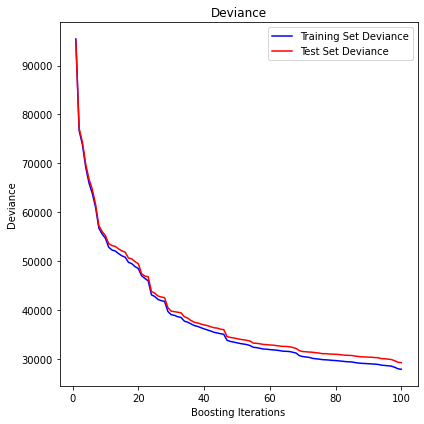

In [12]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    pipeline.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

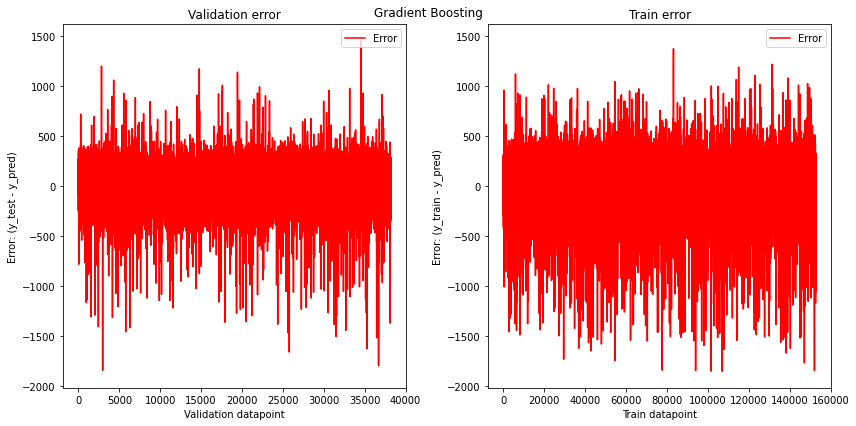

In [13]:
# Show Error on Validation Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred)), y_test - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

# Show Error on Training Set
y_pred = np.array(list(pipeline.staged_predict(X_train)))[-1]
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
plt.title("Train error")
plt.plot(np.arange(len(y_pred)), y_train - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")
fig.tight_layout()
plt.suptitle("Gradient Boosting")
plt.show()

In [14]:
# Decision Tree
from sklearn import tree
pipeline = tree.DecisionTreeRegressor()
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

DecisionTreeRegressor()

11032.322704939474


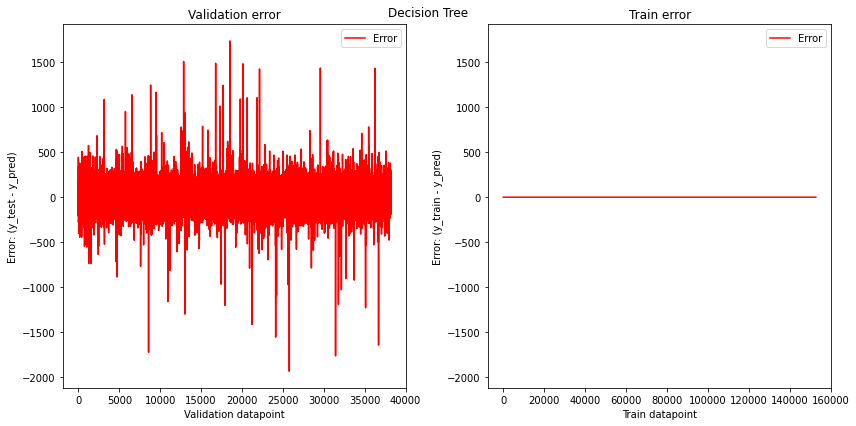

In [15]:
y_pred = np.array(list(pipeline.predict(X_test)))
data = {'y_pred': y_pred,
        'y_test': y_test}
df = pd.DataFrame(data)
df.to_csv('validation_predictions_decisiontree.csv', index=False)
print(mean_squared_error(y_test, y_pred))

# Show Error on Validation Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred)), y_test - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

# Show Error on Training Set
y_pred = np.array(list(pipeline.predict(X_train)))
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
plt.title("Train error")
plt.plot(np.arange(len(y_pred)), y_train - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")
fig.tight_layout()
plt.suptitle("Decision Tree")
plt.show()

In [16]:
from sklearn.decomposition import PCA, IncrementalPCA
# PCA
n_components = 5
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

pipeline = tree.DecisionTreeRegressor()
# Fit the pipeline to the training data
pipeline.fit(X_train_pca, y_train)

DecisionTreeRegressor()

156390.59686131464


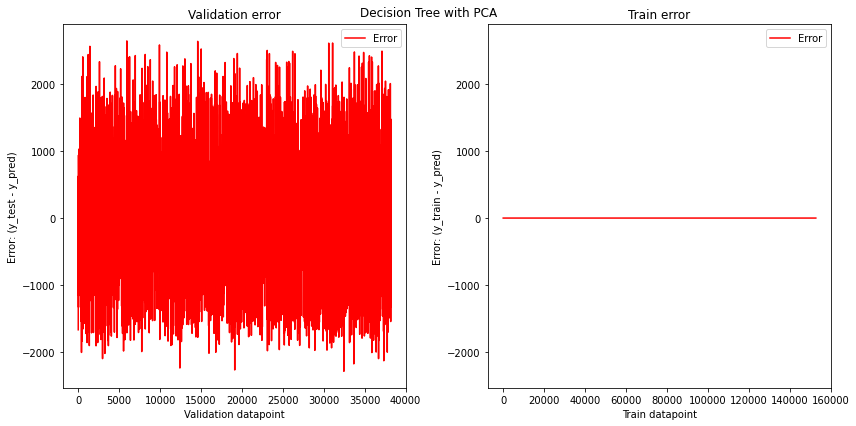

In [17]:
y_pred = np.array(list(pipeline.predict(X_test_pca)))
data = {'y_pred': y_pred,
        'y_test': y_test}
df = pd.DataFrame(data)
df.to_csv('validation_predictions_decisiontreePCA.csv', index=False)
print(mean_squared_error(y_test, y_pred))

# Show Error on Validation Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred)), y_test - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

# Show Error on Training Set
y_pred = np.array(list(pipeline.predict(X_train_pca)))
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
plt.title("Train error")
plt.plot(np.arange(len(y_pred)), y_train - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")
fig.tight_layout()
plt.suptitle("Decision Tree with PCA")
plt.show()

In [19]:
from sklearn.neural_network import MLPRegressor
pipeline = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1)

pipeline.fit(X_train, y_train)

c:\Users\karan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=1e-05, hidden_layer_sizes=(15,), random_state=1,
             solver='lbfgs')

141953.06938628026


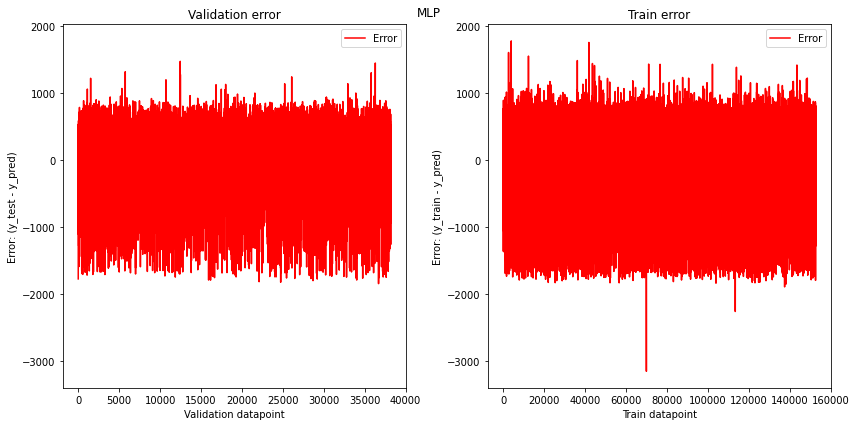

In [20]:
y_pred = np.array(list(pipeline.predict(X_test)))
data = {'y_pred': y_pred,
        'y_test': y_test}
df = pd.DataFrame(data)
df.to_csv('validation_predictions_MLP.csv', index=False)
print(mean_squared_error(y_test, y_pred))

# Show Error on Validation Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred)), y_test - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

# Show Error on Training Set
y_pred = np.array(list(pipeline.predict(X_train)))
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
plt.title("Train error")
plt.plot(np.arange(len(y_pred)), y_train - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")
fig.tight_layout()
plt.suptitle("MLP")
plt.show()